# TIØ4317 Empirical Mini Project
## Problem Statement

In our empirical mini project, we have chosen to examine the Oslo Børs Benchmark Index (OSEBX) using two distinct forecasting approaches. The reason we have chosen to examine the OSEBX is because of the importance of predicting stock market returns for investors and policymakers.  We have decided on the following research question:

***Does univariate time series models like improve the prediction of Oslo Børs Benchmark Index (OSEBX) returns compared to a multiple linear regression model using the macroeconomic indicators consumer price index (CPI), interest rate, and exchange rate (USD/NOK)?***

Traditional econometric models, such as multiple linear regression, rely on macroeconomic indicators to explain market movements, while time series models, such as ARIMA, focus on patterns within historical price data. By comparing these two approaches, we seek to determine whether incorporating historical return patterns improves predictive performance relative to a model based on key macroeconomic variables. This research question aligns with the focus on empirical analysis in the course and contributes to a deeper understanding of the strengths and limitations of different forecasting methods in financial markets.

## Data

In [3]:
# Imports
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from arch import arch_model
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, het_arch, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
import warnings
warnings.filterwarnings("ignore") #Filtering out frequency warnings for readabilty of output

We start by reading the different csv-files that contain the data.

In [5]:
# Define the folder path
data_path = "data/"

# Load datasets
zero_coupon = pd.read_csv(os.path.join(data_path, "zero_coupon_rates.csv"), delimiter=";")
exchange_rates = pd.read_csv(os.path.join(data_path, "usd_nok.csv"), delimiter=";")
inflation = pd.read_csv(os.path.join(data_path, "kpi.csv"), delimiter=";")
osebx = pd.read_csv(os.path.join(data_path, "osebx_prices.csv"), delimiter=";")

# Replace commas with dots in the KPI column and convert to float
inflation["kpi"] = inflation["kpi"].str.replace(",", ".").astype(float)


#### Missing Values
Then, we check for missing values in the data.

In [6]:
datasets = {
    "OSEBX": osebx,
    "Zero Coupon": zero_coupon,
    "Exchange Rates": exchange_rates,
    "Inflation": inflation
}

for name, df in datasets.items():
    missing = df.isnull().sum()
    missing_vars = missing[missing > 0]

    if missing_vars.empty: 
        print(f"{name}: No missing values.")
    else: # If missing values are present, print in which variables it is found. 
        print(f"{name}: Missing values in {', '.join(missing_vars.index)}.")

OSEBX: No missing values.
Zero Coupon: No missing values.
Exchange Rates: No missing values.
Inflation: No missing values.


From the output, we can see that the data does not contain any missing values.

#### Convert to Datetime format
Next, we convert the dates to Datetime format.

Since the inflation data is originally available only on a monthly basis, we apply linear interpolation to estimate daily values. We have chosen to apply linear interpolation instead of for example forward fill because CPI increases approximately linearly over time.

In [7]:
# Convert Date to Datetime format
osebx["Date"] = pd.to_datetime(osebx["Date"])
zero_coupon["TIME_PERIOD"] = pd.to_datetime(zero_coupon["TIME_PERIOD"])
exchange_rates["TIME_PERIOD"] = pd.to_datetime(exchange_rates["TIME_PERIOD"])
inflation["Date"] = pd.to_datetime(inflation["Date"], format="%YM%m")

# Create a full date range from the first to last available date in your dataset
full_date_range = pd.date_range(start=inflation["Date"].min(), end=inflation["Date"].max(), freq="D")

# Create a DataFrame with daily dates
inflation_daily = pd.DataFrame({"Date": full_date_range})

# Merge with the original inflation data (left join) and forward-fill missing values
inflation_daily = inflation_daily.merge(inflation, on="Date", how="left")
inflation_daily["kpi"] = inflation_daily["kpi"].interpolate(method="linear")

#### Compute log returns for OSEBX
It is important for accurate modeling to use log returns instead of index values when analyzing OSEBX. This is because log returns help ensure stationarity, which makes time series models like ARIMA more reliable. 

Also, rename columns to ensure that all dataframes have a column named "Date", so that we can merge all datasets on "Date". After having merged all the datasets to one dataframe, we drop all the columns we are not interested in. Consequently, the columns we are left with are "Date", "kpi", "zero_coupon_rate", "usd_nok_exchange_rate", and "log_return".

In [8]:
# Compute log returns
osebx["log_return"] = np.log(osebx["Close"] / osebx["Close"].shift(1))

#For plotting volatility clusters:
osebx['sqr_return'] = osebx['log_return']**2
osebx['abs_return'] = osebx['log_return'].abs()

osebx.dropna(inplace=True)  # Drop the first row where return cannot be calculated

# Rename columns to "Date"
zero_coupon.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)
exchange_rates.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)

# Merge all datasets on 'Date'
df = inflation_daily.merge(zero_coupon, on="Date", how="inner")
df = df.merge(exchange_rates, on="Date", how="inner")
df = df.merge(osebx, on="Date", how="inner") 

df = df.drop(columns=["Close", "High", "Low", "Open", "Volume",
       "FREQ_x", "Frequency_x", "TENOR_x", "Tenor_x", "DECIMALS_x",
       "FREQ_y", "Frequency_y", "BASE_CUR", "Base Currency",
       "QUOTE_CUR", "Quote Currency", "TENOR_y", "Tenor_y", "DECIMALS_y",
       "CALCULATED", "UNIT_MULT", "Unit Multiplier", "COLLECTION",
       "Collection Indicator"])

df.rename(columns={"OBS_VALUE_x": "zero_coupon_rate"}, inplace=True)
df.rename(columns={"OBS_VALUE_y": "usd_nok_exchange_rate"}, inplace=True)

print(df.head())

        Date        kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return  \
0 2015-03-03  99.225806             1.540                 7.7091    0.005967   
1 2015-03-04  99.238710             1.546                 7.7441   -0.012511   
2 2015-03-05  99.251613             1.567                 7.7207    0.011992   
3 2015-03-06  99.264516             1.639                 7.7917    0.002769   
4 2015-03-09  99.303226             1.676                 7.8992   -0.006572   

   sqr_return  abs_return  
0    0.000036    0.005967  
1    0.000157    0.012511  
2    0.000144    0.011992  
3    0.000008    0.002769  
4    0.000043    0.006572  


#### Multicollinearity
Multicollinearity occurs when two or more independent variables are highly correlated. This makes it difficult to isolate their individual effects on the dependent variable and can lead to unstable coefficient estimates. Therefore, it is important to check for multicollinearity to ensure the model provides reliable estimates and to avoid redundant predictors.


We check for multicollinearity by computing the correlation matrix.

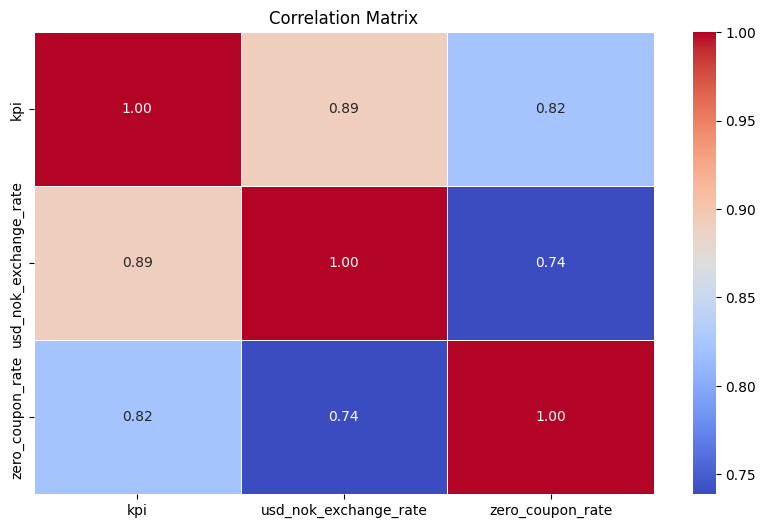

In [9]:
# Compute the correlation matrix
selected_columns = ["kpi", "usd_nok_exchange_rate", "zero_coupon_rate"]
corr_matrix = df[selected_columns].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We define highly correlated values to have a correlation coefficient >0.9. Because all variables have a correlation coefficient below 0.9, we decide to keep all of the explanatory variables. However, we notice that especially between usd_nok_exchange_rate and kpi and between zero_coupon_rate and kpi the correlation coefficient is close to the boundary. 

#### Stationarity
After having checked for correlation, we check for stationarity by applying the Augmented Dickey-Fuller (ADF) test. Stationarity means that a time series has constant statistical properties over time. This includes mean, variance, and autocorrelation. It is crucial to check stationarity because many forecasting models, like ARIMA and regression, assume stationarity for reliable predictions.

In [10]:
from statsmodels.tsa.stattools import adfuller


# Check for stationarity 
def adf_test(series, var_name):
    result = adfuller(series.dropna())  
    status = "Stationary" if result[1] < 0.05 else "Non-stationary"

    return [var_name, f"{result[0]:.4f}", f"{result[1]:.4f}", status]

# Run ADF tests on all relevant variables
stationarity = [
    adf_test(df["log_return"], "Log Return"),
    adf_test(df["zero_coupon_rate"], "Zero Coupon Rate"),
    adf_test(df["usd_nok_exchange_rate"], "USD/NOK Exchange Rate"),
    adf_test(df["kpi"], "CPI")
]

# Print results in a formatted table
headers = ["Variable", "ADF Statistic", "p-value", "Result"]
print(tabulate(stationarity, headers=headers, tablefmt="pretty"))


+-----------------------+---------------+---------+----------------+
|       Variable        | ADF Statistic | p-value |     Result     |
+-----------------------+---------------+---------+----------------+
|      Log Return       |   -15.8678    | 0.0000  |   Stationary   |
|   Zero Coupon Rate    |    -0.5795    | 0.8755  | Non-stationary |
| USD/NOK Exchange Rate |    -1.4185    | 0.5734  | Non-stationary |
|          CPI          |    1.7132     | 0.9982  | Non-stationary |
+-----------------------+---------------+---------+----------------+


The output indicates that the variables "zero coupon rate," "USD/NOK exchange rate," and "CPI" are non-stationary. To ensure stationarity, we apply first differences to these columns. Applying first differences removes trend and stabilizes variance by subtracting the previous value from the current value.

In [11]:
# Transform to stationary variables by applying first differences
df["d_kpi"] = df["kpi"].diff()
df["d_zero_coupon_rate"] = df["zero_coupon_rate"].diff()
df["d_usd_nok_exchange_rate"] = df["usd_nok_exchange_rate"].diff()

df = df.dropna()

# Run ADF tests after applying first differences on all relevant variables
post_diff_stationarity = [
    adf_test(df["d_zero_coupon_rate"], "Zero Coupon Rate"),
    adf_test(df["d_usd_nok_exchange_rate"], "USD/NOK Exchange Rate"),
    adf_test(df["d_kpi"], "CPI")
]

# Print results in a table format
headers = ["Variable", "ADF Statistic", "p-value", "Stationarity"]
print(tabulate(post_diff_stationarity, headers=headers, tablefmt="pretty"))


+-----------------------+---------------+---------+--------------+
|       Variable        | ADF Statistic | p-value | Stationarity |
+-----------------------+---------------+---------+--------------+
|   Zero Coupon Rate    |   -45.8067    | 0.0000  |  Stationary  |
| USD/NOK Exchange Rate |   -50.8674    | 0.0000  |  Stationary  |
|          CPI          |    -6.7596    | 0.0000  |  Stationary  |
+-----------------------+---------------+---------+--------------+


From the output, we can see that all the variables now are stationary.

As the explanatory variables used in the Multiple Linear Regression model are also time series of their own, we need to shift all entries, such that they are incorporated as the previous lag. This is to respect the time-dependency of our data. Consequently, we cannot use values unknown at the time of prediction, we can only use the data we actually have at the time.

In [12]:
#Lag the X-matrix
df["d_kpi"] = df["d_kpi"].shift(1)
df["d_zero_coupon_rate"] = df["d_zero_coupon_rate"].shift(1)
df["d_usd_nok_exchange_rate"] = df["d_usd_nok_exchange_rate"].shift(1)

#Drop first rows as these are noe null:
df = df.dropna()

#### Split into training and testing data
We split the data into a training set and a test set in order to evaluate the different models performance on unseen data. The training set is used to fit the model, while the test set assesses how well the model generalizes to new data. By using a separate test set, we ensure that our model’s predictions are not just tailored to historical data, but are robust.

In [13]:
# Define the split percentage (e.g., 80% train, 20% test)
split_idx = int(len(df) * 0.8)

# Split the data
train_df_orig = df.iloc[:split_idx].copy()  # First 80% for training
test_df_orig = df.iloc[split_idx:].copy()   # Last 20% for testing

# Define training and testing sets
X_train_orig, y_train_orig = train_df_orig[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], train_df_orig['log_return']
X_test_orig, y_test_orig = test_df_orig[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], test_df_orig['log_return']


## Empirical Analysis
### Multiple Linear Regression (MLR)


In [14]:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()

X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

train_df = train_df_orig.copy()
test_df = train_df_orig.copy()

#### Autocorrelation
Start by fitting a model to the training set, and then proceed to check for autocorrelation, which measures the correlation of a variable with itself over successive time intervals. Ignoring autocorrelation leads to inefficient OLS estimates, making standard errors unreliable and increasing the risk of incorrect inferences. 

In [15]:
# Add constant for intercept
X_train_ols = sm.add_constant(X_train)

# Train OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

Define a function to test for autocorrelation using Breusch-Godfrey test.

In [16]:
def breusch_godfrey_test(model, nlags=1):
    # Perform the Breusch-Godfrey test
    lm_stat, p_value, f_stat, f_p_value = acorr_breusch_godfrey(model, nlags=nlags)

    # Print the test name and results
    print("Breusch-Godfrey Test for Autocorrelation")
    print("="*40)
    print(f"LM Statistic: {lm_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"F-Statistic: {f_stat:.4f}")
    print(f"F-Test P-Value: {f_p_value:.4f}")
    print("="*40)

    # Interpretation of the p-value
    if p_value < 0.05:
        print("Autocorrelation detected in residuals (reject H0).")
    else:
        print("No significant autocorrelation detected (fail to reject H0).")


In [17]:
# Test if autocorrelation is present in our model         
breusch_godfrey_test(ols_model, nlags=1)

Breusch-Godfrey Test for Autocorrelation
LM Statistic: 0.3573
P-Value: 0.5500
F-Statistic: 0.3564
F-Test P-Value: 0.5506
No significant autocorrelation detected (fail to reject H0).


Since the P-value is >0.05, we do not reject the null hypothesis. This means that we do not have evidence to conclude that autocorrelation is present.

#### Heteroskedasticity
We continue by testing for heteroskedasticity. This is important because we assume homoskedasticity, which means that all the errors have the same variance. Identifying heteroskedasticity is important because it affects standard errors, confidence intervals, and hypothesis testing reliability in OLS regression.

We test if the homoskedasticity assumption holds by using the ARCH test, as it is well-suited for time-series data because it detects time-dependent variance. 

In [18]:
residuals = ols_model.resid

arch_test = het_arch(residuals)

print(f"ARCH Test Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

ARCH Test Statistic: 472.5920163761905
p-value: 3.154601977639388e-95


To address the strong heteroskedasticity identified by the ARCH test, we use heteroskedasticity-consistent (HC) standard error estimates. This is to ensure valid inference in our regression model. Since our training dataset consists of approximately 2000 observations, we choose HC3 since it is well-suited for medium to large sample sizes. This improves the robustness of our statistical inference, meaning we can trust our p-values and confidence intervals despite our model having heteroscedasticity. 

In [19]:
model_robust = ols_model.get_robustcov_results(cov_type='HC3')

print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.153
Date:                Wed, 02 Apr 2025   Prob (F-statistic):             0.0240
Time:                        11:40:06   Log-Likelihood:                 6075.5
No. Observations:                1978   AIC:                        -1.214e+04
Df Residuals:                    1974   BIC:                        -1.212e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Performance Evaluation
Now, we want to evaluate the performance of our Multiple Linear Regression (MLR) model. 

After having done this, we use the robust model to make predictions and compute the performance metrics Mean Absolute Percentage Error (MAPE), Mean Squared Error (MSE), and Mean Absolute Error (MAE).

In [20]:
X_test = sm.add_constant(X_test)

y_pred = model_robust.predict(X_test)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
mse = mean_squared_error(y_test, y_pred)  
mae = mean_absolute_error(y_test, y_pred) 

results_MLR = [
    ["Metric", "Value"],
    ["MAPE (%)", f"{mape:.4f}"],
    ["MSE", f"{mse:.4f}"],
    ["MAE", f"{mae:.4f}"]
]

print(tabulate(results_MLR, headers="firstrow", tablefmt="grid"))

+----------+----------+
| Metric   |    Value |
+==========+==========+
| MAPE (%) | 132.275  |
+----------+----------+
| MSE      |   0.0001 |
+----------+----------+
| MAE      |   0.0059 |
+----------+----------+


**Mean Absolute Percentage Error (MAPE)**

A MAPE value of **132.275%** indicates that, on average, the model's predictions deviate from the actual values by more than twice their magnitude. This indicates clearly that the model struggles to make accurate predictions, and is likely due to a combination of the model not being able to capture the complex dynamics in the explanatory variables and the fact that log returns are very small values. Therefore, a small mistake in the prediction can lead to a large percentage error.

**Mean Squared Error (MSE)**

The MSE value of **0.0001** seems quite low, however, this is quite misleading. As noted earlier, the scale of the dependent variable is small, which makes the squared errors appear low even if the relative percentage error is large.

**Mean Absolute Error (MAE)**

The MAE value of **0.0059** represents the average absolute error in raw terms and indicates small deviations in absolute terms. However, the reason for such a low MAE value is the small scale of the dependent variable. This makes the absolute errors to seem small even if the relative error is large. 

**Conclusion**

While the MSE and MAE values appear low, the extremely high MAPE highly suggests that the model performs poorly in predicting the dependent variable. The small scale of the log returns of the OSEBX makes the absolute errors seem small but leads to large percentage errors. Also, the low **adjusted R squared value of 0.005** further confirms that the model has weak explanatory power. 

Overall, the model is not reliable for forecasting OSEBX returns and requires improvements.

### Univariate Time Series Models

Before we start our time series modeling, we need to perform some exploratory data analysis, that might help tailor how we model the predicting model for our returns. We wish to model the $\textit{Expected return}$ given the available information at the current timestep, the same way the linear regression model works. The key is to distinguish features from the returns time series itself that help explain the variance in the returns. By testing our MLR model against such a model, we can conclude whether the external macroeconomic factors help explain the variance better or worse than the returns themselves. 

Extract mean return and empirical standard deviation:

In [21]:
mean_return = df['log_return'].mean()
std = df['log_return'].std()

print("Mean return:", mean_return, "Standard error:", std)

Mean return: 0.00036417752464489934 Standard error: 0.01068445528374052


As we can see, the mean return is centered around zero, whilst the volatility is of a significantly larger magnitude. As we have already tested the stationarity of the returns, $and$ shown that the variance is not homoskedastic, we wish to plot the different autocorrelation relationships of our series. But first, lets take a look at the distribution of our return series:

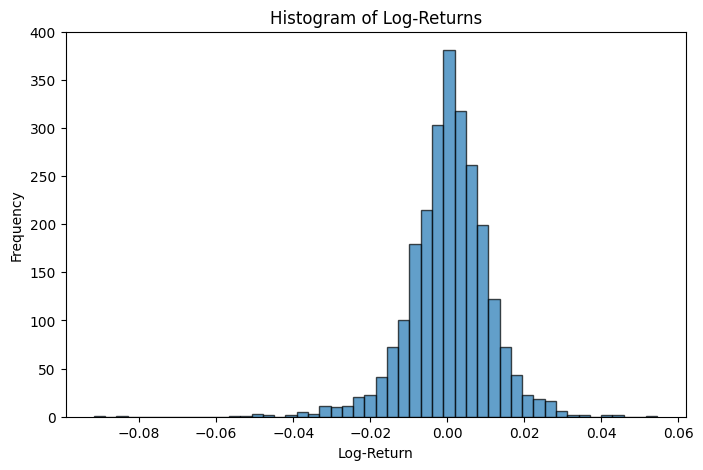

In [22]:
#Plot the distributed log-returns:

plt.figure(figsize=(8, 5))
plt.hist(df['log_return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Log-Returns")
plt.xlabel("Log-Return")
plt.ylabel("Frequency")
plt.show()


As the plot shows, we have returns distributed closely around zero, as expected. Furthermore, we see that the tails of our distribution are very widespread, some with return 8 times the standard deviation. Thereby, we find it most reasonable to use a t-distribution when estimating models later on, as opposed to the regular normal distribution assumption, as it more realistically reflects the returns we have observed in the data.

#### Autocorrelation 
Next lets plot ACF and PACF of the returns to check for autocorrelation

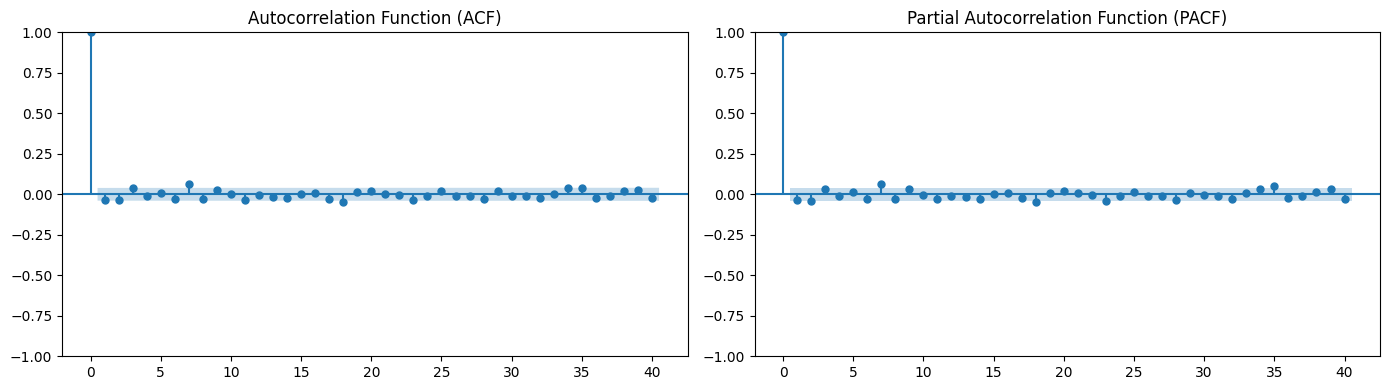

In [23]:
#Plot the acf and pacf of the differenced data:
time_series = df[['Date', 'log_return', 'sqr_return', 'abs_return']].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(time_series['log_return'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(time_series['log_return'], lags=40, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

As we can see from the ACF and PACF of the logarithmic returns, nothing stands out. In traditional financial time series modeling, logarithmic returns are typically stationary, and behave close to white noise. This fits with the underlying $\textit{efficient market hypothesis}$, that reflects that returns of assets, such as Oslo Børs, are white noise and thereby $\textit{not}$ predictable. 

We still see an interesting spike at 7 days prior, indicating that there might be a seasonal relationship between the returns a week ago and the current return. Therefore we want to test a SARIMA approach to incorporate this insight. The standard ARMA(1,1) is also commonly used as a benchmark model to test predictability of separate models against, so we test this model as well. Since our returns are stationary with mean zero and $\textit{low to none}$ pure autocorrelation in the asset returns, a pure mean value predictor, commonly referred to as just ARMA(0,0) will also be used as a baseline. The mean value predictor at 0 is essentially the efficient market hypothesis in action.

#### Implementation of models:

In [24]:
model_df = time_series.copy()

model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df.set_index('Date', inplace=True)

# Set frequency explicitly (e.g., business days or daily)
model_df = model_df.asfreq('D')  # D' for calendar day

# Define the models: (p,d,q) and seasonal (P,D,Q,s)
model_configs = {
    
    #pure ARMA models:
    "ARMA(0,0)": ((0, 0, 0), (0, 0, 0, 0)),
    "ARMA(1,0)": ((1, 0, 0), (0, 0, 0, 0)),
    "ARMA(0,1)": ((0, 0, 1), (0, 0, 0, 0)),
    "ARMA(1,1)": ((1, 0, 1), (0, 0, 0, 0)),
    
    #Seasonal models:
    "SARIMA(1,0,1)(1,0,0)[7]": ((1, 0, 1), (1, 0, 0, 7)),
    "SARIMA(1,0,1)(0,0,1)[7]": ((1, 0, 1), (0, 0, 1, 7)),
    "SARIMA(1,0,1)(1,0,1)[7]": ((1, 0, 1), (1, 0, 1, 7)),
    "SARIMA(1,0,0)(1,0,0)[7]": ((1, 0, 0), (1, 0, 0, 7)),
    "SARIMA(1,0,0)(0,0,1)[7]": ((1, 0, 0), (0, 0, 1, 7)),
    "SARIMA(1,0,0)(1,0,1)[7]": ((1, 0, 0), (1, 0, 1, 7)),
    "SARIMA(0,0,1)(1,0,1)[7]": ((0, 0, 1), (1, 0, 1, 7)),
    "SARIMA(0,0,1)(1,0,0)[7]": ((0, 0, 1), (1, 0, 0, 7)),
    "SARIMA(0,0,1)(0,0,1)[7]": ((0, 0, 1), (0, 0, 1, 7)),
    "SARIMA(0,0,0)(1,0,1)[7]": ((0, 0, 0), (1, 0, 1, 7)),
    "SARIMA(0,0,0)(1,0,0)[7]": ((0, 0, 0), (1, 0, 0, 7)),
    "SARIMA(0,0,0)(0,0,1)[7]": ((0, 0, 0), (0, 0, 1, 7)),
}

# Fit and store results
results_summary = {}

for name, (order, seasonal_order) in model_configs.items():
    model = SARIMAX(
        model_df["log_return"],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit(disp=False)
    results_summary[name] = {
        "AIC": fit.aic,
        "BIC": fit.bic,
        "Log-Likelihood": fit.llf
    }

# Convert to DataFrame for comparison
benchmark_results = pd.DataFrame(results_summary).T
print(benchmark_results)


                                  AIC           BIC  Log-Likelihood
ARMA(0,0)               -15421.799165 -15415.604936     7711.899583
ARMA(1,0)               -15427.444899 -15415.056440     7715.722450
ARMA(0,1)               -15418.640002 -15406.252096     7711.320001
ARMA(1,1)               -15416.194347 -15397.612488     7711.097173
SARIMA(1,0,1)(1,0,0)[7] -15391.151438 -15366.382263     7699.575719
SARIMA(1,0,1)(0,0,1)[7] -15383.916164 -15359.148097     7695.958082
SARIMA(1,0,1)(1,0,1)[7] -15383.895445 -15352.935361     7696.947723
SARIMA(1,0,0)(1,0,0)[7] -15393.419139 -15374.842258     7699.709570
SARIMA(1,0,0)(0,0,1)[7] -15393.417045 -15374.840163     7699.708522
SARIMA(1,0,0)(1,0,1)[7] -15391.525040 -15366.755865     7699.762520
SARIMA(0,0,1)(1,0,1)[7] -15384.920888 -15360.152820     7696.460444
SARIMA(0,0,1)(1,0,0)[7] -15401.081801 -15382.504090     7703.540901
SARIMA(0,0,1)(0,0,1)[7] -15386.923219 -15368.347168     7696.461609
SARIMA(0,0,0)(1,0,1)[7] -15385.819008 -15367.242

As AIC and BIC provide feedback on the model fit to complexity ratio, we extract he following models as our baseline for the SARIMA, with a tradeoff between complexity, information criterion and log-likelihood:

- ARMA(0,0)
- ARMA(1,0)
- SARIMA(0,0,1)(1,0,0)[7]

#### Volatility Clustering 
Next we plot squared returns and absolute returns to check for volatility clustering:

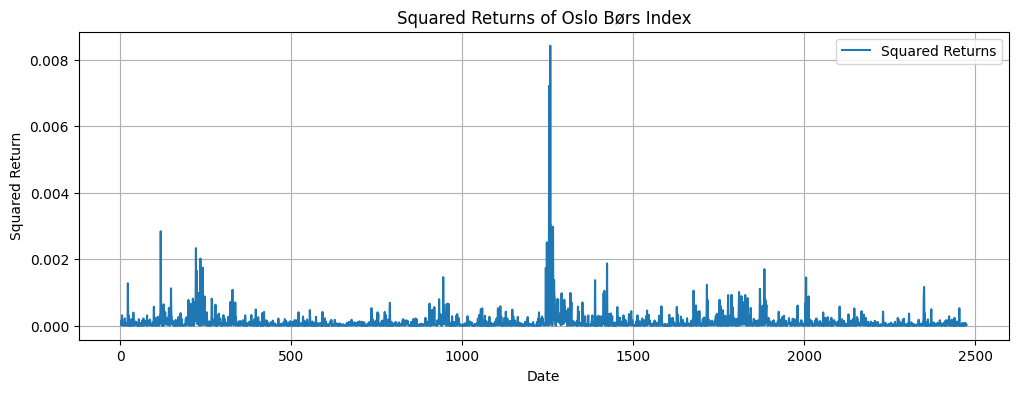

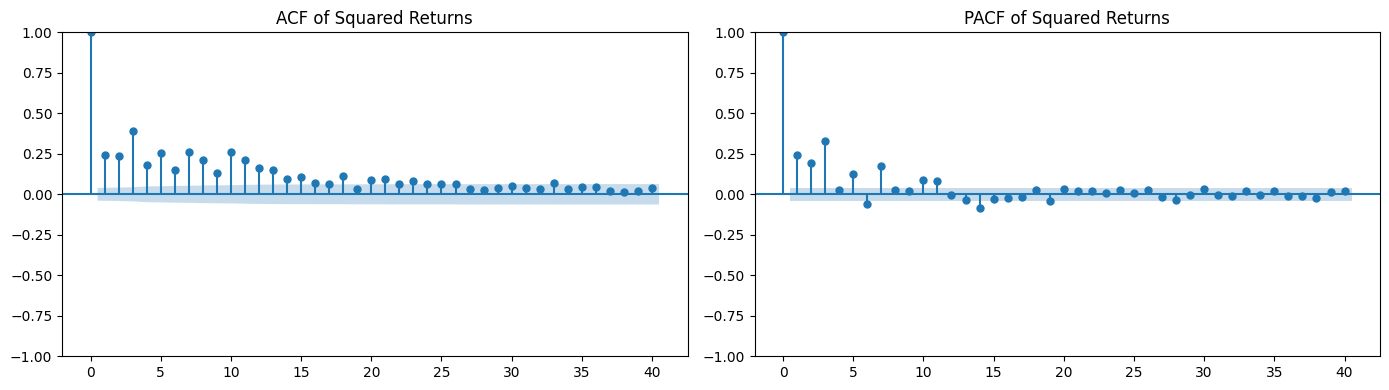

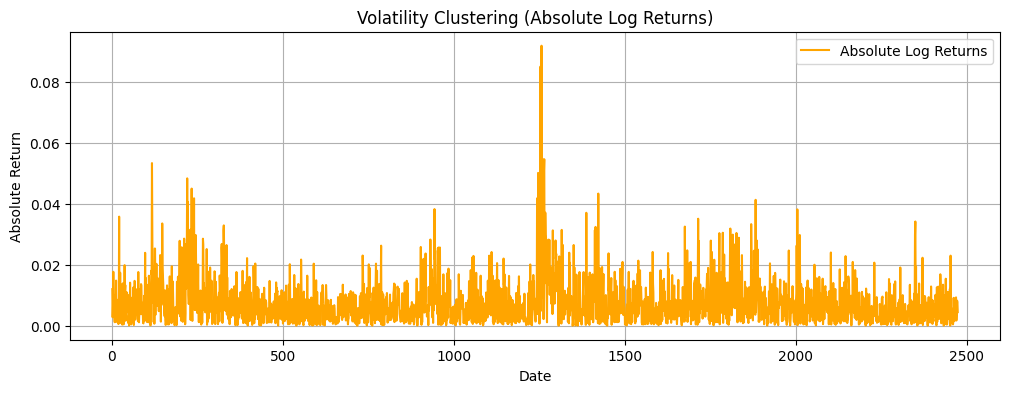

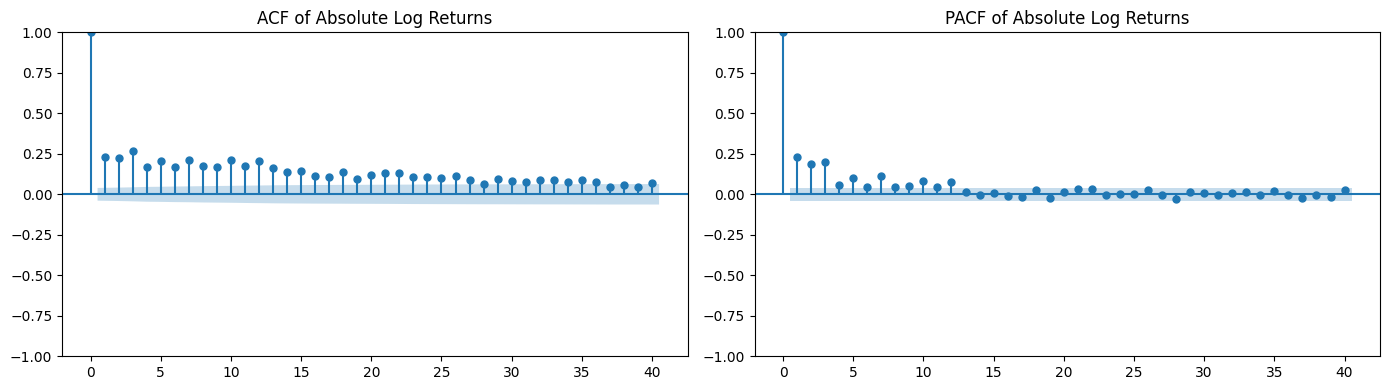

In [25]:
# Squared Returns Line Plot
plt.figure(figsize=(12, 4))
plt.plot(time_series['sqr_return'], label='Squared Returns')
plt.title('Squared Returns of Oslo Børs Index')
plt.xlabel('Date')
plt.ylabel('Squared Return')
plt.legend()
plt.grid(True)
plt.show()

# ACF and PACF of Squared Returns 
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(time_series['sqr_return'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF of Squared Returns")
plot_pacf(time_series['sqr_return'].dropna(), lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF of Squared Returns")
plt.tight_layout()
plt.show()

# Absolute Log Returns Line Plot
plt.figure(figsize=(12, 4))
plt.plot(time_series['abs_return'], label='Absolute Log Returns', color='orange')
plt.title('Volatility Clustering (Absolute Log Returns)')
plt.xlabel('Date')
plt.ylabel('Absolute Return')
plt.legend()
plt.grid(True)
plt.show()

# ACF and PACF of Absolute Returns 
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(time_series['abs_return'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF of Absolute Log Returns")
plot_pacf(time_series['abs_return'].dropna(), lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF of Absolute Log Returns")
plt.tight_layout()
plt.show()


As the plots of ACF and PACF of the squared and absolute returns show, there is strong serial dependency in our time series, even though the simple autocorrelation of log-returns might only have a significant spike at lag 7. These results, in addition to the statistically significant ARCH effect of our resiudals from the MLR, serve as a strong intuition for our choice of using volatility modeling for the Oslo Børs returns. To provide further insight we perform the Ljung-Box test on the squared returns series to test for serial autocorrelation. We test the following:

$H_0:$ The data is independently distributed, against $H_1:$, we have serial dependencies

In [26]:
# Perform Ljung-Box test at multiple lags:
ljung_box_result_sqr = acorr_ljungbox(time_series['sqr_return'], lags=[10, 20, 30], return_df=True)

print("Ljung-Box Test on Squared Returns:")
print(ljung_box_result_sqr)

print()

ljung_box_result_log = acorr_ljungbox(time_series['log_return'], lags=[10, 20, 30], return_df=True)

print("Ljung-Box Test on log Returns:")
print(ljung_box_result_log)

Ljung-Box Test on Squared Returns:
        lb_stat      lb_pvalue
10  1460.601128  8.140896e-308
20  1818.235185   0.000000e+00
30  1914.093196   0.000000e+00

Ljung-Box Test on log Returns:
      lb_stat  lb_pvalue
10  26.390027   0.003250
20  41.630770   0.003089
30  50.188164   0.011855


As the test shows, we have extremely strong evidence to reject the null hypothesis, and thereby conclude that the data has serial dependencies, and a volatility model is appropriate. we also see that the log-returns have presence of autocorrelation, meaning that we should adjust the residuals for ARCH effects after fitting our ARMA models. 

#### Volatility Behavior of the Oslo Børs Index

The plots above illustrate the behavior of log returns, their absolute values, and their squared values over time. We clearly observe a **massive spike in volatility** in the middle of the dataset, corresponding to the **Covid-19 outbreak in 2020** — a globally disruptive event that led to extreme uncertainty and financial market instability.

Beyond this one-off shock, we also observe **persistent clusters of higher volatility** across different periods, particularly visible in the plots of **absolute** and **squared log returns**. These clusters indicate that **volatility is not constant over time**, but rather shows signs of **volatility clustering** — a well-documented phenomenon in financial markets where large changes tend to be followed by large changes (of either sign), and small changes by small changes.

This volatility clustering behavior violates the **homoskedasticity assumption** of ARIMA/SARIMA models, and provides strong empirical justification for applying **GARCH-type models**, which are specifically designed to handle **time-varying conditional variance**. In other words, GARCH models not only acknowledge that volatility changes over time, but also model it explicitly based on past shocks and past volatility. This is appropriate in our case, as the Ljung-Box test shows that the squared returns series has strong serial dependencies.

Thus, the Oslo Børs index return data supports that **we should adjust residuals from SARIMA with a GARCH approach** when forecasting financial returns or understanding risk dynamics. We fit the GARCH model instead of the ARCH model due to its ability to capture the persistence of shocks whithout needing a high order of lags.

Following the procedure described in the book: Analyzis of Financial Time Series by Tsay et al, the next step after observing the volatility clustering effect -and testing prior residuals for ARCH effects, is to fit a volatility model to the returns. As we have shown previously, ARMA(1,0) has a high log-likelihood compared to the rest of the ARMA models, and will be used as the mean-equation. The idea is that since we have strong serial correlation in the squared returns, and thereby volatility clustering, todays volatility might impact tomorrows return. To capture this hypothetical relationship we explore the GARCH-M model with AR(1). As financial theory assumes risk aversion in the market, we expect investors to react differently to periods of $bad$ volatility compared to $good$ volatility. I.E the risk premium is larger during periods of bad volatility. To captures this skewed effect we use the $\textbf{Assymetric GARCH-M Model}$. As explained previously, we use the t-distribution as the estimated population distribution of our returns, due to the fat tails we observed in the exploratory data analysis.

#### GARCH-M Model
We test the GARCH-M model to capture hypothetical volatility drift:

In [27]:
# Step 1: Rescale returns for numerical stability (multiply by 100)
ts_garch_test = time_series.copy()
ts_garch_test['log_return_scaled'] = ts_garch_test['log_return'] * 100

# Step 2: Fit an AR(1)-GARCH(1,1) model to the scaled returns
# This will give us conditional volatility estimates.
garch_model = arch_model(
    ts_garch_test['log_return_scaled'],
    mean='ARX',       # AR model in the mean
    lags=1,           # AR(1)
    o = 1,            #Enable assymetric effect of volatility
    vol='GARCH',      # GARCH specification for volatility
    p=1,              # GARCH order 1
    q=1,              # ARCH order 1
    dist='t'     # Use the t distribution as return series has fat tails
)
garch_fit = garch_model.fit(disp='off')

# Step 3: Extract the conditional variance and shift by 1 period
# We shift because we want yesterday's conditional variance to predict today’s return.
ts_garch_test['cond_var'] = garch_fit.conditional_volatility ** 2
ts_garch_test['lag_cond_var'] = ts_garch_test['cond_var'].shift(1)

# Step 4: Create a lagged return column (AR(1) component)
ts_garch_test['lag_return'] = ts_garch_test['log_return_scaled'].shift(1)

# Create a copy of the DataFrame slice to avoid warnings
df_model = ts_garch_test.dropna(subset=['lag_return', 'lag_cond_var', 'log_return_scaled']).copy()

# Assign new columns for bad and good volatility components:
df_model.loc[:, 'lag_bad_vol'] = np.where(df_model['lag_return'] < 0, df_model['lag_cond_var'], 0)
df_model.loc[:, 'lag_good_vol'] = np.where(df_model['lag_return'] >= 0, df_model['lag_cond_var'], 0)

# Step 5: Run an OLS regression to estimate the assymetric GARCH-M model
X = sm.add_constant(df_model[['lag_return', 'lag_bad_vol', 'lag_good_vol']])
y = df_model['log_return_scaled']
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      log_return_scaled   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.981
Date:                Wed, 02 Apr 2025   Prob (F-statistic):            0.00767
Time:                        11:40:15   Log-Likelihood:                -3663.7
No. Observations:                2471   AIC:                             7335.
Df Residuals:                    2467   BIC:                             7359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0318      0.026      1.214   

As we can see from the results above, we have a low R-squared which is expected for a financial return series. However, we see that the coefficients for good and bad volatility are significant, entailing that the nature of the volatility $\textit{most likely}$ has a significant impact on the next return, supporting the assumption of investor risk aversion. 

### Predictions from the estimated models

To use the univariate time-series models to predict the day ahead Oslo Børs returns, we must set up our training and testing data a little different than when we benchmarked the MLR model. We still wish to test its performance on the 20% of unseen returns, but since we use lagged values of the time series itself, we must include the available information at the prediction time, as we only predict $one$ timestep ahead. This is often referred to as $\textit{rolling one-step-ahead forecasting}$. This means that we re-estimate each model for every new observation, as observations many steps into the future is assumed to be $non-predictable$ and thereby not interesting to evaluate either. By re-calculating the model with the information gained at each new timestep, we make sure that the results we obtain are from actual day-ahead forecasting.

As a quick recap here is our univariate time series models we benchmark MLR against:
- ARMA(0,0)
- ARMA(1,0)
- SARIMA(0,0,1),(1,0,0)[7]
- GARCH-M (1,1), AR(1)

Set up training and test data:

In [28]:
# 1. Prepare Data
ts = time_series.copy()
ts['log_return_scaled'] = ts['log_return'] * 100

# Split: 80% train, 20% test
n = len(ts)
train_size = int(n * 0.8)
train_ts = ts.iloc[:train_size].copy()
test_ts = ts.iloc[train_size:].copy()

# 2. Initialize Storage
forecast_dates = []
forecast_results = {
    'GARCH-M': [],
    'ARMA(0,0)': [],
    'ARMA(1,0)': [],
    'SARIMA(0,0,1)(1,0,0)[7]': [],
    'Actual': []
}

# Rolling training data
rolling_ts = train_ts.copy()

# 3. Rolling Forecast Loop
for t, row in test_ts.iterrows():
    forecast_dates.append(t)
    y_train = rolling_ts['log_return_scaled'].dropna()

    # ARMA(0,0)
    try:
        model_00 = SARIMAX(y_train, order=(0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
        result_00 = model_00.fit(disp=False)
        pred_00 = result_00.forecast(steps=1).iloc[0]
    except:
        pred_00 = np.nan

    # ARMA(1,0)
    try:
        model_10 = SARIMAX(y_train, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
        result_10 = model_10.fit(disp=False)
        pred_10 = result_10.forecast(steps=1).iloc[0]
    except:
        pred_10 = np.nan

    # SARIMA(0,0,1)(1,0,0)[7]
    try:
        model_sarima = SARIMAX(y_train,
                               order=(0, 0, 1),
                               seasonal_order=(1, 0, 0, 7),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        result_sarima = model_sarima.fit(disp=False)
        pred_sarima = result_sarima.forecast(steps=1).iloc[0]
    except:
        pred_sarima = np.nan

    # GARCH-M Model (Asymmetric)
    try:
        garch_model = arch_model(
            y_train,
            mean='ARX', lags=1,
            o=1, vol='GARCH', p=1, q=1,
            dist='t'
        )
        garch_fit = garch_model.fit(disp='off')

        rolling_ts['cond_var'] = garch_fit.conditional_volatility ** 2
        rolling_ts['lag_cond_var'] = rolling_ts['cond_var'].shift(1)
        rolling_ts['lag_return'] = rolling_ts['log_return_scaled'].shift(1)

        df_model = rolling_ts.dropna(subset=['lag_return', 'lag_cond_var', 'log_return_scaled']).copy()
        df_model['lag_bad_vol'] = np.where(df_model['lag_return'] < 0, df_model['lag_cond_var'], 0)
        df_model['lag_good_vol'] = np.where(df_model['lag_return'] >= 0, df_model['lag_cond_var'], 0)

        X = sm.add_constant(df_model[['lag_return', 'lag_bad_vol', 'lag_good_vol']])
        y = df_model['log_return_scaled']
        ols_model = sm.OLS(y, X).fit()

        last_return = rolling_ts['log_return_scaled'].iloc[-1]
        last_cond_var = rolling_ts['cond_var'].iloc[-1]

        if pd.isna(last_return) or pd.isna(last_cond_var):
            pred_garch = np.nan
        else:
            input_data = {
                'const': 1.0,
                'lag_return': last_return,
                'lag_bad_vol': last_cond_var if last_return < 0 else 0.0,
                'lag_good_vol': last_cond_var if last_return >= 0 else 0.0
            }
            X_fc = pd.DataFrame([input_data])
            pred_garch = ols_model.predict(X_fc).iloc[0]
    except Exception as e:
        print(f"[GARCH-M] Exception at {t}: {e}")
        pred_garch = np.nan

    # Store Results
    forecast_results['GARCH-M'].append(pred_garch)
    forecast_results['ARMA(0,0)'].append(pred_00)
    forecast_results['ARMA(1,0)'].append(pred_10)
    forecast_results['SARIMA(0,0,1)(1,0,0)[7]'].append(pred_sarima)
    forecast_results['Actual'].append(ts.loc[t, 'log_return_scaled'])

    # Update training data with actual value at t
    rolling_ts = pd.concat([rolling_ts, ts.loc[[t]]])

# 4. Build Final Forecast DataFrame
forecast_df = pd.DataFrame(forecast_results, index=forecast_dates)
print(forecast_df.head())


       GARCH-M  ARMA(0,0)  ARMA(1,0)  SARIMA(0,0,1)(1,0,0)[7]    Actual
1980  0.014713        0.0  -0.022332                -0.041416  2.464487
1981  0.048858        0.0  -0.095956                -0.096120 -0.249552
1982  0.057420        0.0   0.009754                 0.072575  0.128487
1983  0.013014        0.0  -0.005024                -0.046024 -0.125259
1984  0.056385        0.0   0.004898                 0.073206  0.010512


#### Performance evaluation
Now we calculate our performance metrics before comparing the results against the MLR model and their implications:

In [29]:
# Convert forecasts and actuals back to the original scale by dividing by 100.
actual_rescaled = forecast_df['Actual'].values / 100.0
models = ["ARMA(0,0)", "ARMA(1,0)", "SARIMA(0,0,1)(1,0,0)[7]", "GARCH-M"]

results = []
for model in models:
    preds_rescaled = forecast_df[model].values / 100.0
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_rescaled - preds_rescaled) / actual_rescaled)) * 100
    mse = mean_squared_error(actual_rescaled, preds_rescaled)
    mae = mean_absolute_error(actual_rescaled, preds_rescaled)
    results.append([model, f"{mape:.5f}", f"{mse:.5f}", f"{mae:.5f}"])

headers = ["Model", "MAPE (%)", "MSE", "MAE"]
print(tabulate(results, headers=headers, tablefmt="grid"))


+-------------------------+------------+-------+---------+
| Model                   |   MAPE (%) |   MSE |     MAE |
+=========================+============+=======+=========+
| ARMA(0,0)               |    100     | 6e-05 | 0.00602 |
+-------------------------+------------+-------+---------+
| ARMA(1,0)               |    107.643 | 6e-05 | 0.00602 |
+-------------------------+------------+-------+---------+
| SARIMA(0,0,1)(1,0,0)[7] |    124.555 | 6e-05 | 0.00605 |
+-------------------------+------------+-------+---------+
| GARCH-M                 |    105.761 | 6e-05 | 0.00601 |
+-------------------------+------------+-------+---------+


As expected, the ARMA(0,0) has a MAPE of 100%, as it only predicts 0 for every return, and thereby the error will simply be 100% every time. Even though the difference is very minor, we see that the assymetric GARCH-M model outperforms the other models on MAE and MAPE. As the scale of log-returns is very small, this slight performance increase is still worth considering.

## Conclusion
We wanted to investigate whether the use of univariate time series models improve the prediction of Oslo Børs Benchmark Index (OSEBX) returns compared to an MLR model using macroeconomic indicators. Based on our result, the GARCH-M model demonstrated the best predictive performance. It outperforms MLR in terms of MAPE and MSE, even though the difference in MAE was minimal.

The GARCH-M model achieved the lowest MAPE (105.78%) among the models tested, indicating it provided the most accurate relative predictions. MLR had a significantly higher MAPE (132.27%), which shows greater percentage error in its forecasts. Additionally, all univariate models had a lower MSE (6e-05) compared to MLR (0.0001), meaning they produced smaller squared errors on average. The MAE values were very similar across all models. These findings indicate that the absolute errors remained close between models, while GARCH-M provided better error reduction in terms of percentage deviation and squared errors. 

However, overall, the predictive performance of all models was poor. A MAPE exceeding 100% suggests that the different models’ predictions deviate from actual returns by more than the true values themselves, on average. This makes them practically useless for financial forecasting. The consistently high errors indicate that OSEBX returns are highly complex and likely influenced by factors not captured in our models. Consequently, this suggests that the underlying dynamics of stock market returns are not effectively captured by neither univariate time series models nor a basic MLR approach.

The differences in performance can be connected to the strengths and weaknesses of each modeling approach. The univariate time series models, particularly GARCH-M, are well-suited for capturing time-dependent volatility in financial data. This could suggest that they are effective at modeling stock returns that exhibit periods of high and low variance. However, they do not incorporate external macroeconomic factors, which could be crucial in understanding broader market trends. The poor performance of the ARMA and SARIMA models suggests that simple autoregressive and moving average components alone are insufficient for modeling OSEBX returns. The reason is that the stock market is non-stationary of nature and due to the presence of structural breaks. 

On the other hand, MLR integrates macroeconomic indicators, which theoretically should enhance predictive accuracy. However, the model suffers from heteroscedasticity, meaning that its error variance changes over time, reducing the reliability of its estimates. Additionally, the high correlation between macroeconomic variables introduces multicollinearity, making it difficult to separate the individual effects of CPI, interest rate, and exchange rate on OSEBX returns. Furthermore, our study relies on data from only the last 10 years. This could result in models that cannot fully capture long-term economic cycles or structural shifts in the market. Moreover, this limits the effectiveness of both modeling approaches.

In conclusion, our results indicate that GARCH-M provides better predictive performance than MLR in terms of MAPE and MSE, although the absolute error differences are small. However, because of the overall poor predictive accuracy of all models, neither approach is suitable for reliable forecasting of OSEBX returns. Future research could explore hybrid models that integrate both time series dynamics and macroeconomic indicators or investigate machine learning techniques that may overcome these limitations.

## Use of LLMs
### How are LLMs used?
We have used ChatGPT for two different purposes listed below:

* **Debugging of code:** Sometimes we encountered errors or coding issues difficult to resolve on our own. ChatGPT was then used to get quick explanations of error messages and suggest alternative approaches.  
* **Spell check:** When working with writing the report, ChatGPT was used in some parts to check grammar, spelling and phrasing. This contributed to making our writing clearer and more professional.

### What are our experiences?
Overall, our experience with AI has been positive. It has saved us time, provided quick support when needed and improved our language. However, we recognize that AI is not always correct, making it essential to verify its responses before applying them to our project. This was particularly seen when using ChatGPT for debugging, as it sometimes struggled to understand the specific context of our implementation.
